## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import random 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import binarize
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Reshape
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

In [3]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [4]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
91753,00022879_000.png,No Finding,0,22879,75,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022879_000.png
90915,00022651_017.png,Pneumothorax,17,22651,20,M,PA,2624,2770,0.143,0.143,NaN,/data/images_010/images/00022651_017.png
56673,00014095_003.png,Atelectasis|Effusion|Infiltration,3,14095,60,F,PA,2602,2577,0.143,0.143,NaN,/data/images_007/images/00014095_003.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
75328,00018488_005.png,Fibrosis|Pneumothorax,5,18488,47,M,PA,2021,2021,0.194311,...,0,1,0,0,0,0,0,0,0,1
96659,00025468_000.png,No Finding,0,25468,11,F,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
11216,00002923_002.png,No Finding,2,2923,19,M,PA,2048,2500,0.168000,...,0,0,0,0,0,1,0,0,0,0
14889,00003887_001.png,Fibrosis,1,3887,23,F,PA,2048,2500,0.171000,...,0,1,0,0,0,0,0,0,0,0
18409,00004893_063.png,Cardiomegaly,63,4893,33,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
102993,00027455_010.png,Infiltration,10,27455,55,M,PA,2021,2021,0.194311,...,0,0,0,1,0,0,0,0,0,0
6788,00001827_000.png,No Finding,0,1827,52,F,PA,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
36846,00009703_002.png,Atelectasis,2,9703,66,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
88831,00022028_001.png,Edema|Nodule,1,22028,13,F,AP,3056,2544,0.139000,...,0,0,0,0,0,0,1,0,0,0
39082,00010234_000.png,No Finding,0,10234,55,F,PA,2048,2500,0.168000,...,0,0,0,0,0,1,0,0,0,0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia'] == 1, 'Yes' , 'No')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,No
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,No
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,No
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,No
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,No


In [8]:
all_xray_df_yes = all_xray_df[all_xray_df['Pneumonia'] == 1]
all_xray_df_yes.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,1,Yes
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,1,0,Yes
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,1,0,Yes
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,1,1,0,Yes
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,Yes


In [9]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
 13 

## Create your training and testing data:

In [10]:
def create_splits(**vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    df, test_size, target_class = vargs['dataframe'], vargs['test_size'], vargs['target_class']
    train_data, val_data = train_test_split(df, test_size=test_size, stratify=df[target_class])
    
    ## proportion of pneumonia in train and test
    
    prop_train = len(train_data[train_data['pneumonia_class'] == 'Yes'])/len(train_data)
    prop_val = len(val_data[val_data['pneumonia_class'] == 'Yes'])/len(val_data)
    print('Proportion of Pneumonia in Training Set %s' % (prop_train))
    print('Proportion of Pneumonia in Validation Set %s' % (prop_val))
    
    # Now we need to balance equal number of positive and negative pneumonia cases in Training set
    
    pos_idxs = train_data[train_data['pneumonia_class'] == 'Yes'].index.tolist()
    neg_idxs = train_data[train_data['pneumonia_class'] == 'No'].index.tolist()
    neg_idxs = random.sample(neg_idxs, len(pos_idxs))
    train_data = train_data.loc[pos_idxs + neg_idxs]
    prop_train = len(train_data[train_data['pneumonia_class'] == 'Yes'])/len(train_data)
    print('Proportion of Pneumonia in Training Set after balancing %s' % (prop_train))
    
    ## Now we need to make sure that validation set reflects real world scenario, hence we create a validation set
    ## with 25% pneumonina cases
    
    pos_idxs = val_data[val_data['pneumonia_class'] == 'Yes'].index.tolist()
    neg_idxs = val_data[val_data['pneumonia_class'] == 'No'].index.tolist()
    neg_idxs = random.sample(neg_idxs, 3*len(pos_idxs))
    val_data = val_data.loc[pos_idxs + neg_idxs]
    prop_val = len(val_data[val_data['pneumonia_class'] == 'Yes'])/len(val_data)
    print('Proportion of Pneumonia in Validation Set after balancing %s' % (prop_val))
    
    
    return train_data, val_data

In [11]:
train_data, val_data = create_splits(dataframe=all_xray_df, test_size=0.2, target_class='pneumonia_class')

Proportion of Pneumonia in Training Set 0.012765340706386016
Proportion of Pneumonia in Validation Set 0.012754191937210132
Proportion of Pneumonia in Training Set after balancing 0.5
Proportion of Pneumonia in Validation Set after balancing 0.25


In [12]:
## Since we are using VGG16, we need to reshape our input to adjust with the architecture

IMG_SIZE = (224,224)
BATCH_SIZE = 64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1.0/255.0,
                             horizontal_flip=True,
                             vertical_flip=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             rotation_range=15
                            )
    
    return my_idg


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    
    df = vargs['dataframe']
    train_idg = my_image_augmentation()
    train_gen = train_idg.flow_from_dataframe(dataframe=df,
                                        directory=None,
                                        x_col='path',
                                        y_col='pneumonia_class',
                                        class_mode='binary',
                                        target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE
                                       )

    return train_gen


def make_val_gen(**vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    
    df = vargs['dataframe']
    
    val_idg = ImageDataGenerator(rescale=1.0/255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe=df,
                                          directory=None,
                                          x_col='path',
                                          y_col='pneumonia_class',
                                          class_mode='binary',
                                          target_size=IMG_SIZE,
                                          batch_size=64
                                         )
    
    
    return val_gen

In [14]:
## Get train and validation generator

train_gen = make_train_gen(dataframe=train_data)


Found 2290 validated image filenames belonging to 2 classes.


In [15]:
val_gen = make_val_gen(dataframe=val_data)

Found 1144 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [17]:
print('ValX Shape: {}  and valY shape: {}'.format(valX.shape, valY.shape))

ValX Shape: (64, 224, 224, 3)  and valY shape: (64,)


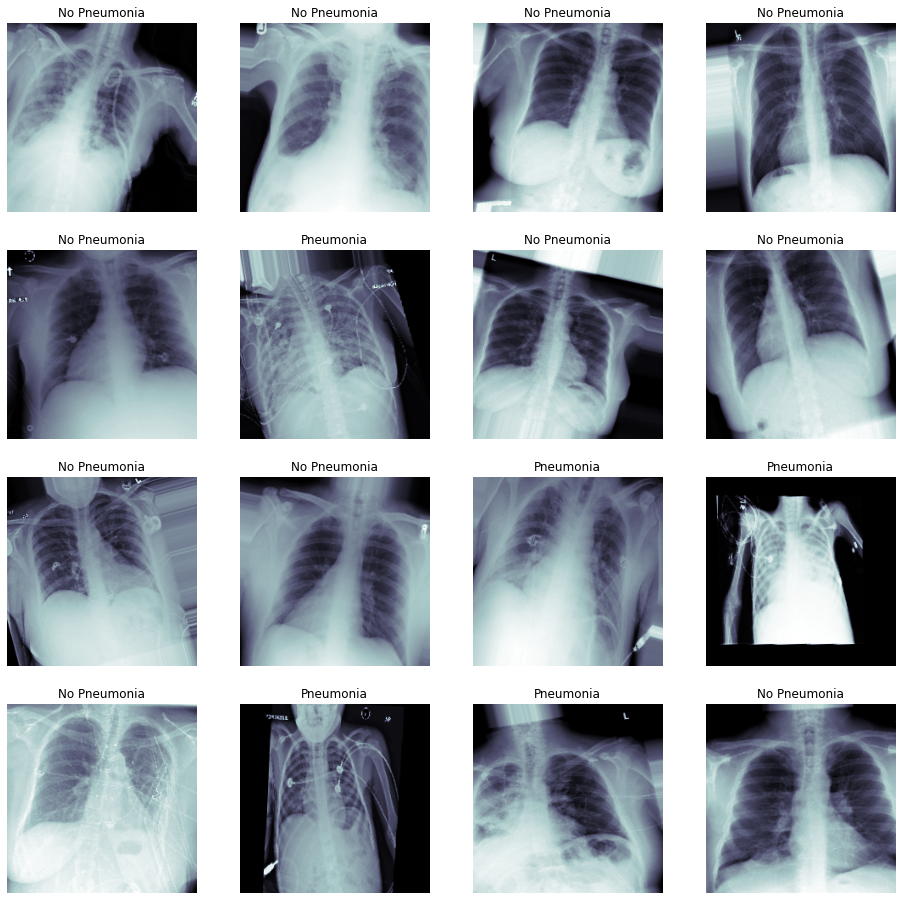

In [18]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [19]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    ## Freez the weights of the intial 16 layers
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable=False
        
    ## Lets see all the layers
    
    print('VGG16 after freezing initial 17 layers')
    for layer in vgg_model.layers:
        print('Layer {} Trainable {}'.format(layer.name, layer.trainable))
    
    return vgg_model


In [20]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    vgg_model = load_pretrained_model()
    
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.25))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.20))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [27]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    fpr, tpr, threshold = roc_curve(t_y, p_y)
    ax.plot(fpr,tpr, label='%s (AUC:%.2f)' % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

## Let's plot precision-recall curve

def pr_curve(ground_truth, probability):
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    precision, recall, threshold = precision_recall_curve(ground_truth, probability)
    ax.plot(recall, precision, label='%s (AP Score:%.2f)' % ('Pneumonia', average_precision_score(ground_truth, probability)))
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    

#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    
    N = len(history.history['loss'])
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0,N), history.history['loss'], label='Training Loss')
    plt.plot(np.arange(0,N), history.history['val_loss'], label='Validation Loss')
    plt.plot(np.arange(0,N), history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(np.arange(0,N), history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training Loss and Accuracy on X-ray Image Dataset')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='lower left')
    
    return

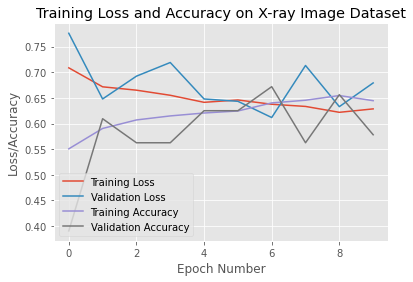

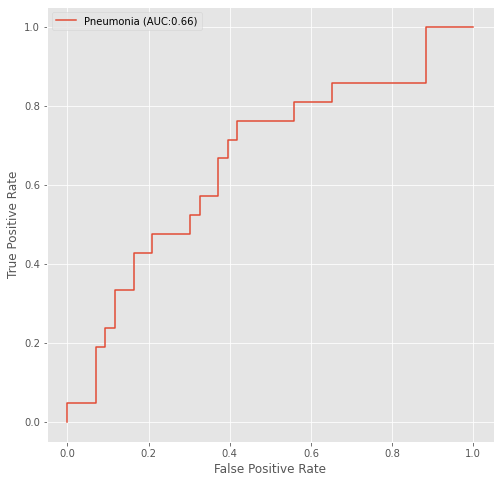

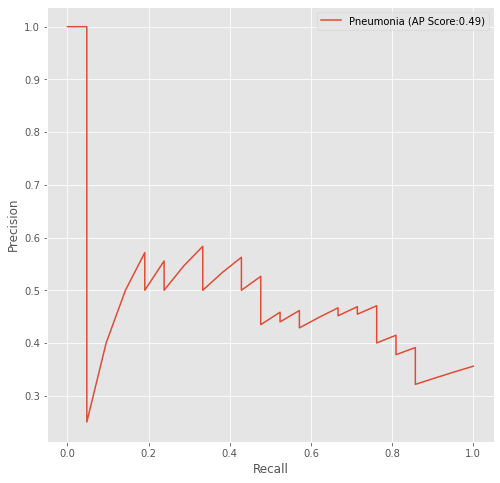

In [28]:
## plot figures

# Todo

## Plotting History

plot_history(history)

## Plotting ROC-AUC Curve

plot_auc(valY, pred_Y)

## Plotting Precision-Recall Curve

pr_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [29]:
## Let's calulate F1 Score

def cal_F1Score(precision, recall):
    f1_score = 2*(precision * recall)/(precision + recall)
    return f1_score

In [30]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

def plot_f1_score():
    
    precision, recall, threshold = precision_recall_curve(valY, pred_Y)
    f1_scores = [cal_F1Score(precision[i], recall[i]) for i in range(len(threshold))]
    max_f1_score_idx = np.argmax(f1_score)
    
    print('Max F1 Score and corresponding Precision, recall and Threshold\n')
    print('Precision: '+ str(precision[max_f1_score_idx]))
    print('Recall: '+ str(recall[max_f1_score_idx]))
    print('Threshold: '+ str(threshold[max_f1_score_idx]))
    print('F1 Score: ' + str(f1_scores[max_f1_score_idx]))
    
    plt.figure()
    plt.plot(threshold, f1_scores)
    plt.title("F1-Score vs Threshold")
    plt.xlabel("Epoch Number")
    plt.ylabel("F1-Score")
    plt.show()
    return threshold[max_f1_score_idx]

Max F1 Score and corresponding Precision, recall and Threshold

Precision: 0.3559322033898305
Recall: 1.0
Threshold: 0.14898804
F1 Score: 0.525


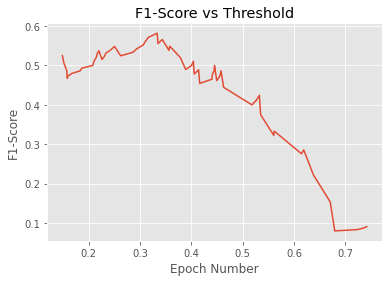

In [31]:
## plot_precision_recall_curveet the threshold for the model

YOUR_THRESHOLD = plot_f1_score()

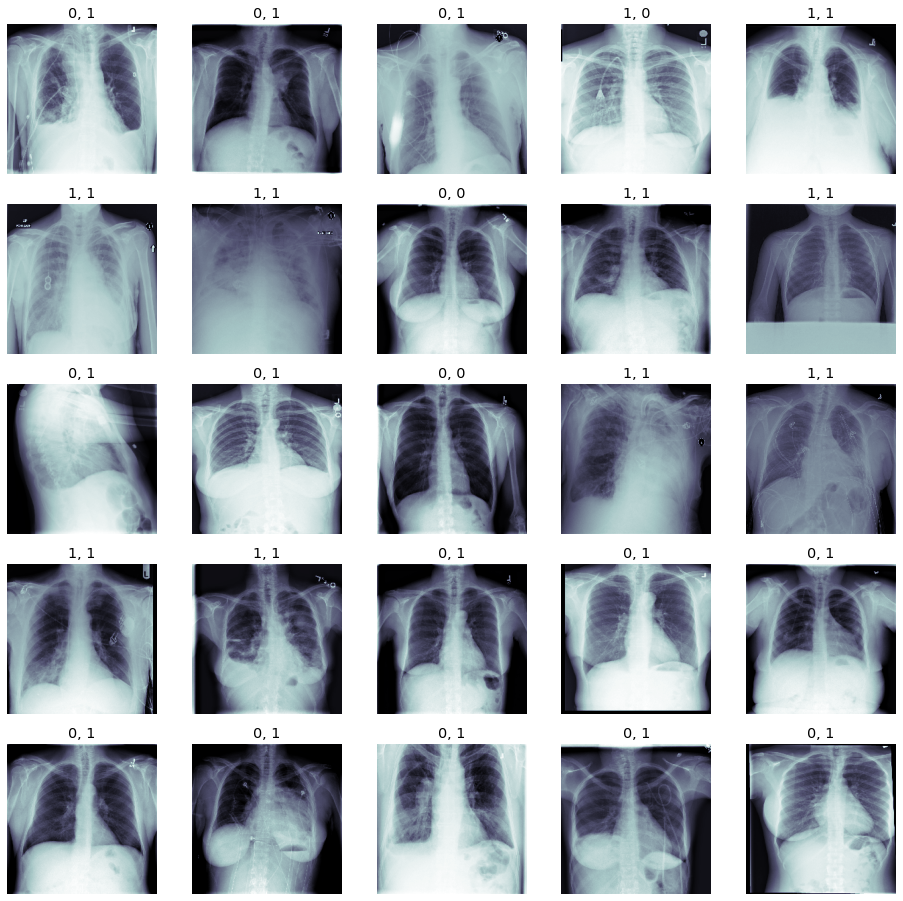

In [32]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:32], valY[0:32], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [33]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)